## Descarga de información geoespacial 
### Autor: Mario Caceres Reyna

In [3]:
import ee

try:
    ee.Initialize()
    print("Google Earth Engine ha sido inicializado correctamente.")
except ee.EEException:
    print("Google Earth Engine no ha sido autenticado, por favor corre el comando 'earthengine authenticate' en tu terminal.")


Google Earth Engine ha sido inicializado correctamente.


In [1]:
import ee

# Inicializa la API de Earth Engine
ee.Initialize()

# Carga el asset de las provincias del Perú
provincias = ee.FeatureCollection('projects/ee-mariocaceresreyna25/assets/PROVINCIAS_PERU')

# Filtra para obtener la provincia de Chumbivilcas
chumbivilcas = provincias.filter(ee.Filter.eq('PROVINCIA', 'CHUMBIVILCAS'))

# Carga el Modelo Digital de Elevación, por ejemplo, SRTM
dem = ee.Image('USGS/SRTMGL1_003')

# Recorta el DEM usando la provincia de Chumbivilcas como región de interés
dem_chumbivilcas = dem.clip(chumbivilcas)

# Define los parámetros para la exportación al Google Drive
task = ee.batch.Export.image.toDrive(**{
    'image': dem_chumbivilcas,
    'description': 'DEM_Chumbivilcas',
    'folder': 'GEE_Downloads',
    'fileNamePrefix': 'DEM_Chumbivilcas',
    'scale': 30,  # Puedes ajustar este valor según la resolución deseada
    'region': chumbivilcas.geometry(),
    'fileFormat': 'GeoTIFF'
})

# Inicia la tarea de exportación
task.start()

print("Exportación iniciada, revisa el progreso en Google Earth Engine Code Editor o en tu Google Drive.")


Exportación iniciada, revisa el progreso en Google Earth Engine Code Editor o en tu Google Drive.


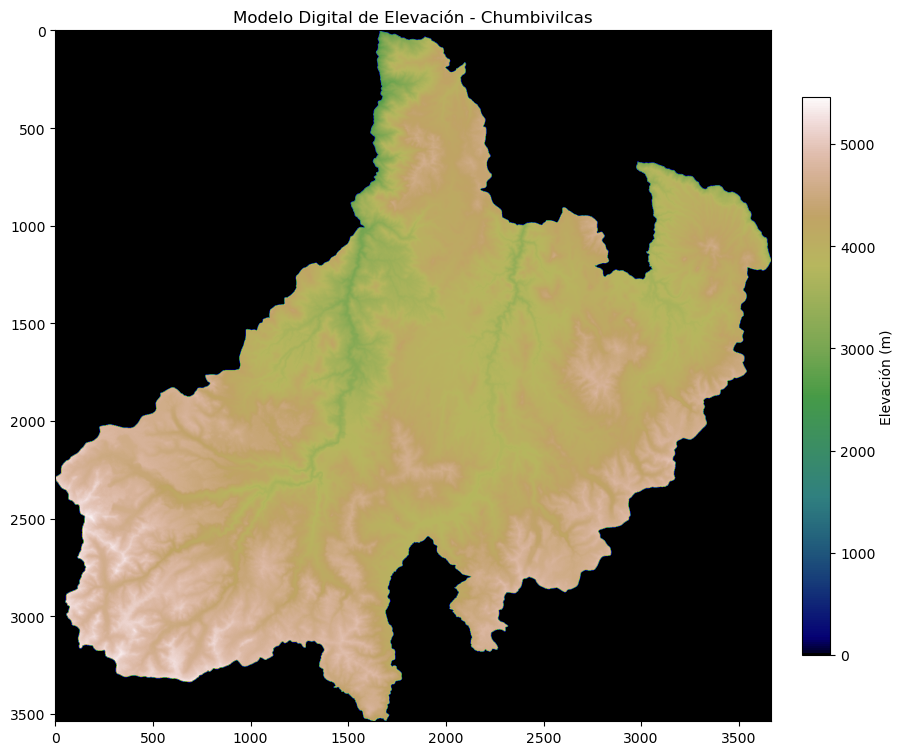

In [4]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Ruta al archivo DEM GeoTIFF
dem_path = 'E:/Talleres/Rutas_optimas/Insumos/DEM_Chumbivilcas.tif'

# Cargar el DEM con Rasterio
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Lee la primera banda

# Definir la paleta de colores para la visualización
# Esta es una paleta que va desde el verde (bajas altitudes) hasta el blanco (altas altitudes)
palette = plt.cm.gist_earth

# Visualizar el DEM con la paleta de colores
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(dem, cmap=palette)
ax.set_title('Modelo Digital de Elevación - Chumbivilcas')
fig.colorbar(cax, ax=ax, fraction=0.036, pad=0.04, label='Elevación (m)')
plt.show()


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import shapes
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.spatial import KDTree

# Cargar el shapefile de puntos y el DEM
shapefile_path = 'puntos.shp'  # Asegúrate de cambiar esto por la ruta de tu archivo
dem_path = 'tu_archivo_dem.tif'  # Cambia esto por la ruta de tu archivo DEM

# Leer el shapefile con Geopandas
gdf = gpd.read_file(shapefile_path)

# Asegurarse de que el shapefile tiene al menos dos puntos (A y B)
if len(gdf) < 2:
    raise ValueError("El shapefile debe contener al menos dos puntos.")

# Leer el DEM con Rasterio
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    affine = src.transform

# Convertir el DEM a nodos en un grafo, donde cada píxel es un nodo
mask = dem != src.nodata  # Asumiendo que hay un valor de nodata para ignorar
t = {k: v for k, v in shapes(dem, mask=mask, transform=affine)}
G = nx.Graph()
for shape, value in t.items():
    for i, segment in enumerate(shape['coordinates'][0]):
        if i < len(shape['coordinates'][0]) - 1:
            G.add_edge(segment, shape['coordinates'][0][i + 1], weight=value)

# Extraer las coordenadas de los puntos A y B
points = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
A, B = points[0], points[1]

# Encontrar los nodos más cercanos a A y B en el grafo
tree = KDTree(list(G.nodes))
_, idx_A = tree.query(A)
_, idx_B = tree.query(B)
node_A, node_B = list(G.nodes)[idx_A], list(G.nodes)[idx_B]

# Calcular la ruta óptima basada en el peso (elevación)
route = nx.shortest_path(G, source=node_A, target=node_B, weight='weight')

# Visualizar la ruta
x, y = zip(*route)
fig, ax = plt.subplots()
rasterio.plot.show(dem, ax=ax, cmap='gray')
ax.plot(x, y, color='red')  # Ruta óptima
gdf.plot(ax=ax, color='blue', markersize=50)  # Puntos A y B
plt.show()

